# Common Test I. Multi-Class Classification

In [ ]:
# Run this cell if you are working on Kaggle

import numpy as np 
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


#### Import All Important Libraries

In [ ]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import AUROC, Accuracy
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
torch.manual_seed(123)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##### Define Metrics

In [5]:
auroc = AUROC(task="multiclass", num_classes=3).to(device)
accuracy = Accuracy(task="multiclass", num_classes=3).to(device)

#### Data Loading

In [6]:
train_dir = '/kaggle/input/gsoc2025-common-task-data/dataset/train'
val_dir = '/kaggle/input/gsoc2025-common-task-data/dataset/val'

In [ ]:
def load_npy_to_dataframe(input_dir):
    data = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.npy'):
                npy_path = os.path.join(root, file)
                new_row = {'image': npy_path, 'class': root.split('/')[-1]}

                data.append(new_row)

    return pd.DataFrame(data)


train_df = load_npy_to_dataframe(train_dir)
test_df = load_npy_to_dataframe(val_dir)

In [8]:
train_df.shape, test_df.shape

((30000, 2), (7500, 2))

Label encoder is used to convert categorical labels (text or non-numeric categories) into numerical values.

In [9]:
label_encoder = LabelEncoder()
train_df['Encoded_class'] = label_encoder.fit_transform(train_df['class'])
test_df['Encoded_class'] = label_encoder.fit_transform(test_df['class'])
print(label_encoder.inverse_transform([0, 1, 2]))
train_df.shape, test_df.shape

['no' 'sphere' 'vort']


((30000, 3), (7500, 3))

In [10]:
class_mapping = {
    "0" : "no",
    "1" : "sphere",
    "2" : "vort"
 }
class_mapping

{'0': 'no', '1': 'sphere', '2': 'vort'}

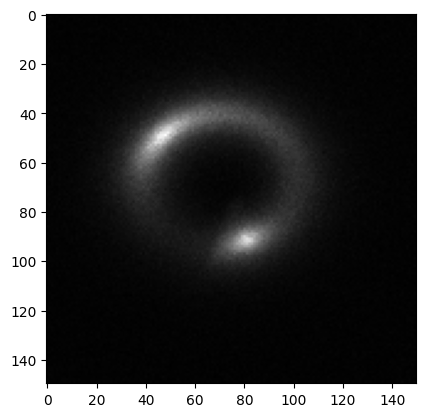

In [11]:
plt.imshow(np.load(train_dir+'/vort/965.npy')[0], cmap='gray')

In [13]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=123)

In [14]:
class GravLenseImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = np.load(img_name).astype(np.float32).reshape(150, 150)
        if self.transform:
            image = self.transform(image)

        return image, self.dataframe.iloc[idx]['Encoded_class']

In [26]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [27]:
dataset = GravLenseImageDataset(dataframe=train_df, transform=train_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

val_dataset = GravLenseImageDataset(dataframe=val_df, transform=test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

test_dataset = GravLenseImageDataset(dataframe=test_df, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
print(f"Batch Sizes")
print(f"Training Data : {dataloader.batch_size}\tValidation Data : {val_dataloader.batch_size}\tTesting Data : {test_dataloader.batch_size}")

Batch Sizes
Training Data : 128	Validation Data : 128	Testing Data : 128


#### Define The Model

In [37]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Dropout(0.4),

            nn.Linear(256, 3)
        )

        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        return self.resnet18(x)

In [38]:
model = Model().to(device)

In [39]:
optimizer = optim.AdamW(model.parameters(), lr=4e-4, weight_decay=1e-3)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0004
    maximize: False
    weight_decay: 0.001
)

In [40]:
criterion = nn.CrossEntropyLoss(reduction='mean').cuda()

In [ ]:
# Validation Function

@torch.no_grad()
def val():
    model.eval()
    ar_roc = 0
    ce_loss = 0
    batches = 0
    for i, batch in enumerate(val_dataloader):

        images, labels = batch
        images = images.to(device).float()
        labels = labels.to(device).long()
        batches += 1

        outputs = model(images)

        loss = criterion(outputs, labels)

        ce_loss += loss.item()
        auroc.update(outputs, labels)

        accuracy.update(outputs, labels)


    print(f"\nVALIDATION:\tAUROC: {auroc.compute():.4f} | Accuracy: {accuracy.compute():.4f} | CE Loss: {(ce_loss/batches):.4f}")
    return ce_loss/batches


In [ ]:
# Testing Function

@torch.no_grad()
def test():
    model.eval()
    ar_roc = 0
    ce_loss = 0
    batches = 0
    for i, batch in enumerate(test_dataloader):

        images, labels = batch
        images = images.to(device).float()
        labels = labels.to(device).long()
        batches += 1

        outputs = model(images)

        loss = criterion(outputs, labels)

        ce_loss += loss.item()
        auroc.update(outputs, labels)

        accuracy.update(outputs, labels)


    print(f"TESTING:\tAUROC: {auroc.compute():.4f} | Accuracy: {accuracy.compute():.4f} | CE Loss: {(ce_loss/batches):.4f}")


In [ ]:
# Training Function

def train():
    model.train()
    ar_roc = 0
    ce_loss = 0
    batches = 0
    for i, batch in enumerate(dataloader):
        if i % 100 == 0:
            print(f"Batch {i}", end="\t")

        images, labels = batch
        images = images.to(device).float()
        labels = labels.to(device).long()
        batches += 1

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        ce_loss += loss.item()
        auroc.update(outputs, labels)
        accuracy.update(outputs, labels)


    print(f"\nTRAINING:\tAUROC: {auroc.compute():.4f} | Accuracy: {accuracy.compute():.4f} | CE Loss: {(ce_loss/batches):.4f}")


In [ ]:
# Training Loop

EPOCHS = 25
curr_best_loss = 99999999
best_model = model
for epoch in range(EPOCHS):
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    train()
    auroc.reset()
    accuracy.reset()
    loss = val()
    if loss < curr_best_loss:
        best_model = model
        curr_best_loss = loss
    auroc.reset()
    accuracy.reset()
    print("_______________________________________________________________________________________________________________________")

print(f"Saving Model....")
torch.save(best_model.state_dict(), "./gsoc25_common_task_model_v2.pth")

Epoch [1/25]
Batch 0	Batch 100	Batch 200	
TRAINING:	AUROC: 0.4982 | Accuracy: 0.3304 | CE Loss: 1.1065

VALIDATION:	AUROC: 0.5019 | Accuracy: 0.3203 | CE Loss: 1.1000
_______________________________________________________________________________________________________________________
Epoch [2/25]
Batch 0	Batch 100	Batch 200	
TRAINING:	AUROC: 0.5483 | Accuracy: 0.3624 | CE Loss: 1.0868

VALIDATION:	AUROC: 0.6482 | Accuracy: 0.3913 | CE Loss: 1.1182
_______________________________________________________________________________________________________________________
Epoch [3/25]
Batch 0	Batch 100	Batch 200	
TRAINING:	AUROC: 0.7540 | Accuracy: 0.5552 | CE Loss: 0.8793

VALIDATION:	AUROC: 0.8041 | Accuracy: 0.5203 | CE Loss: 1.0574
_______________________________________________________________________________________________________________________
Epoch [4/25]
Batch 0	Batch 100	Batch 200	
TRAINING:	AUROC: 0.8757 | Accuracy: 0.7186 | CE Loss: 0.6430

VALIDATION:	AUROC: 0.9335 | Accurac

In [49]:
test()

TESTING:	AUROC: 0.9841 | Accuracy: 0.9081 | CE Loss: 0.3165


### Plotting ROC Curve

AUROC Scores: tensor([0.9906, 0.9732, 0.9885], device='cuda:0')


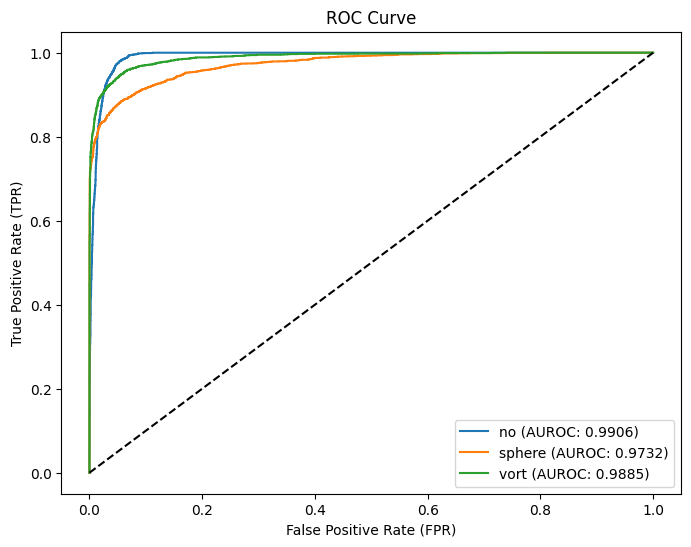

In [ ]:
auroc_chart = torchmetrics.AUROC(num_classes=3, average=None, task="multiclass").to(device)  # Compute per-class AUROC

all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        all_probs.append(outputs)
        all_labels.append(labels)

all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)

# Compute AUROC
auroc_scores = auroc_chart(all_probs, all_labels)
print(f"AUROC Scores: {auroc_scores}")

# Compute TPR and FPR for each class
fpr, tpr, _ = torchmetrics.functional.roc(all_probs, all_labels, num_classes=3, task="multiclass")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i].cpu(), tpr[i].cpu(), label=f'{class_mapping[str(i)]} (AUROC: {auroc_scores[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()
